# CNN project

## Project description - at some point will need to talk about the different types of solution availabel to solve this

### Packages


In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import re
from skimage import exposure

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten

from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator # this is for data augmentation

#tf.keras.preprocessing.image.array_to_img

### Read in data - what is best way of doing this with images - files are .png. The info on the classificationa dn patient number is 

os.walk()?

here we have a folder per patient. In github will need to provide a sample data folder
https://stackoverflow.com/questions/25868109/read-all-files-in-directory-and-subdirectories-in-python

See this post here - it is not actually one folder per patient
https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images/discussion/137446

In [2]:
# os.getcwd()

In [3]:
# os.chdir('D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder')

#### The cell below does a few things, so let's break it down.

#### In our data set each 'patient' (see the readme for caveats here) has their own folder containing two subfolders - one with non-cancerous samples (class0) and one with cancerous samples (class1). The first loop below uses os.walk() to iterate through the folders and subfolders to create a list of all the file names - called image_paths.

#### The second loop goes through all of the filenames in image_path and for each one reads in the corresponding image file and saves it in a list called 'images'

In [4]:
root_dir = 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder'
image_paths = []
images = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        full_path = os.path.join(dirpath, filename)
        image_paths.append(full_path)

In [5]:
for image_path in image_paths:
    try:
        img = Image.open(image_path)
        images.append(img)
    except IOError:
        print(f"Error: Could not read image {image_path}")

In [6]:
images

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2903D076940>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2903D076F70>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2904C124BE0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2904C124B20>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2904C124C40>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2904C124CA0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2904C124D00>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2904C124D60>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2904C124DC0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2904C124E20>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2904C124E80>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=50x50 at 0x2904C124EE0>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB siz

In [7]:
len(images)

1249

In [8]:
image_paths

['D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1001_y1301_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1001_y1351_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1051_y1251_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1051_y1301_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1051_y1351_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1051_y1401_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1051_y1451_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_folder\\12241\\0\\12241_idx5_x1101_y1301_class0.png',
 'D:\\lori_python\\Udacity_Projects\\CNN_Breast_Cancer\\Sample_f

In [9]:
len(image_paths)

1249

### Preparing the data

In [10]:
#### Before going further and creating a list of classes, let's QA the images and check that the dimensions are consistent

In [11]:
example_image = images[0]

height = example_image.height
width = example_image.width

print('image height and width:', height, width) # looks good

image height and width: 50 50


In [12]:
#lets see if this applies to all images

# note this source for help with list comprehension
# https://stackoverflow.com/questions/51761784/how-to-delete-list-elements-based-on-condition-in-python

In [13]:
heights_list = []
widths_list = []

for img in images:
    heights_list.append(img.height)
    widths_list.append(img.width)

deviant_heights = [index for (index, item) in enumerate(heights_list) if item != 50]

print(deviant_heights)

[325]


In [14]:
# Scrolling through the list of images there is one that has dimensions 50 x 1. This is possibly an erro in data generation as image is only one pixel tall

deviant_widths = [index for (index, item) in enumerate(widths_list) if item != 50]

print(deviant_widths)

[744, 745, 746]


In [15]:
#scrolling through the images list again these three images have dimensions 42x50 so are likely still useful
# At this point we want to remove the 50 x 1 and resize the 42 x 50 images. However, thinking ahead if we remove the 50 x 1
# image without removing it's corresponding file path in the image_paths list then this will lead to the images and classes data
# sets being inconsistent with each other. Let's remove the image path correspponding to the 50 x 1 image

In [16]:
# Create a dictionary mapping images to file paths
image_file_dict = dict(zip(map(str, images), image_paths))

# Remove the images you want to remove from the data set
filtered_images = [img for img in images if img.height >= 40]

# Remove the corresponding file paths from the file_paths list
filtered_paths = [image_file_dict[str(image)] for image in filtered_images]


In [17]:
len(filtered_images)

1248

In [18]:
len(filtered_paths)

1248

In [19]:
# Let's create a new list that omits the 50 x 1 image

In [20]:
#images = [img for img in images if img.height >= 40]

In [21]:
#len(images)

In [22]:
#### We have three images that have dimensions 42 x 50. We can resize the images so they can consistent with the rest.

#### I'm aware this isn't the most efficient of elegant way of solving this, as I am resizing images that are already 50 x 50. 
#### However with this amount of data the command still executes almost immediately

In [23]:
resized_images = []

for img in filtered_images:
    resz = img.resize((50, 50))
    resized_images.append(resz)

In [24]:
len(resized_images)

1248

In [25]:
#### Can we repea the process above see if we have any images that aren't 50 x50

In [26]:
heights_list = []
widths_list = []

for img in resized_images:
    heights_list.append(img.height)
    widths_list.append(img.width)

deviant_heights = [index for (index, item) in enumerate(heights_list) if item != 50]

print(deviant_heights)

[]


In [27]:
deviant_widths = [index for (index, item) in enumerate(widths_list) if item != 50]

print(deviant_widths)

[]


In [28]:
#### Great!

### Understanding the data

#### For each image we want to know the class; 0 for non-cancerous or 1 for cancerous. As this information is in the file names, we can get this by iterating through the strings in the file names and extracting the fifth-from-last digit. The data is then saved in a list called 'classes'

In [29]:
classes = []

for name in filtered_paths:
    diagnosis = name[-5]
    classes.append(diagnosis)

In [30]:
classes

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0'

In [31]:
len(classes)

1248

#### Now let's try to understand the data a bit better. Firstly we can compare the number of cancerous and non-cancerous samples in our data set and check the data is a balanced.

In [32]:
diagnosis_df= pd.DataFrame({'class': classes})

In [33]:
diagnosis_df.head()

class
0     0
1     0
2     0
3     0
4     0

In [34]:
len(diagnosis_df)

1248

In [35]:
diagnosis_df.value_counts()

class
0        704
1        544
dtype: int64

In [36]:
Q = diagnosis_df.value_counts()

In [37]:
Q = pd.DataFrame({'count': Q})

In [38]:
Q

count
class       
0        704
1        544

In [39]:
Q = Q.astype('int64')

In [40]:
#Q.index = [int(idx[0]) for idx in Q.index]
#df_value_counts.columns = [int(col[0]) for col in df_value_counts.columns]


<AxesSubplot:xlabel='class'>

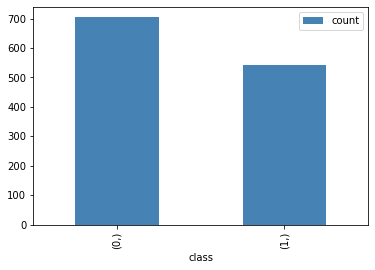

In [41]:
bar_cols = ['orange' if (y < max(Q)) else 'steelblue' for y in Q]

Q.plot(kind='bar', color = bar_cols)

## Why is this all steel blue

#### In our data we have a small majority of non-cancerous samples, though this looks like there are enough observations in each class for a model to be trained on the data. Now as a quick QA, let's see if the number of samples is similar for each 'patient'. Given the previous discussion about how each ID doesn't reflect a unique patient in this data set we don't need to worry if there is an imbalance, but in reality this could provide a useful check that health practitioners have carried out the data generating process correctly.

#### Originally I indented to extract ID numbers from the file names using slicing. However the file names are of different lengths, meaning that using regular expressions was a better approach here

In [42]:
pattern = r"\\(\d+)_"
id = []

for name in image_paths:
    match = re.search(pattern, name)
    if match:
        id_number = match.group(1)
        id.append(id_number)


In [43]:
id

['12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',
 '12241',


In [44]:
id = pd.DataFrame({'id_no': id})

In [45]:
id

id_no
0     12241
1     12241
2     12241
3     12241
4     12241
...     ...
1244  12242
1245  12242
1246  12242
1247  12242
1248  12242

[1249 rows x 1 columns]

In [46]:
id.value_counts()

id_no
12242    1097
12241     152
dtype: int64

#### To get an idea of what kind of images we're dealing with, let's plot a few. Below we have 4 non-cancerous samples and 4 cancerous ones. At a glance there are some differences - for example the cancerous samples tend to have denser blocks of darker pixels, whereas the non-cancerous once tend to have swirls or abstract patterns to them. However, looking at the right-most non-cancerous sample, this has some characteristics of a cancerous sample. For a experienced professional it might be possible to reliably distinguish between the classes by looking at the images, though I doubt many other people could.

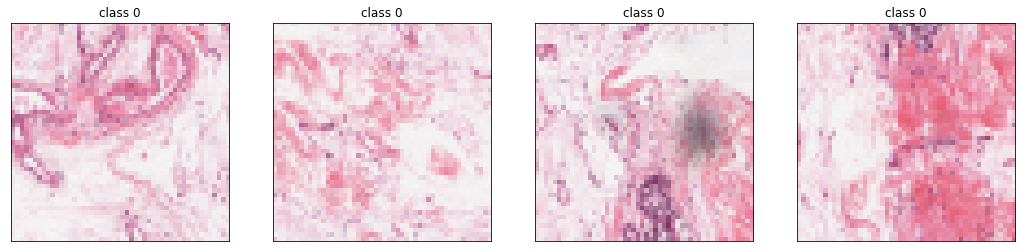

In [47]:
fig = plt.figure(figsize=(18,18))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(resized_images[i])
    ax.set_title('class {}'.format(classes[i]))

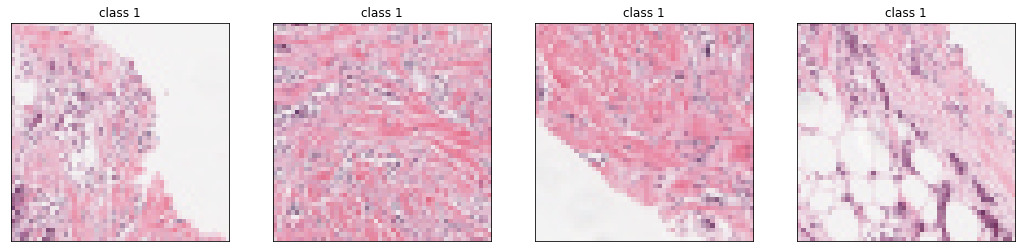

In [48]:
fig = plt.figure(figsize=(18,18))
for i in range(51, 55):
    ax = fig.add_subplot(1, 4, i - 50, xticks=[], yticks=[])
    ax.imshow(resized_images[i])
    ax.set_title('class {}'.format(classes[i]))

In [49]:
### Region of interest?


In [50]:
# IMAGE AUGMENTATION - RANDOM FLIPPING??? DOES THIS BELONG IN THE DATA PREPARATION SECTION?

# Can refer to article below saying how image flipping can improve model performance by effectively creating new data
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

# This is useful guide for doing the aug - refer to in acknowledgments. Need to be aware of what has been deprecated recently
"""
https://keras.io/guides/transfer_learning/
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
"""

'\nhttps://keras.io/guides/transfer_learning/\nhttps://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator\n'

## Modelling

In [51]:
# Both inputs need to be defined as np arrays?
classes = np.array(classes)
classes= classes.astype(int)

In [52]:
image_data = np.array([image.img_to_array(img) for img in resized_images])

In [53]:
type(classes)

numpy.ndarray

In [54]:
classes

array([0, 0, 0, ..., 1, 1, 1])

In [55]:
classes.dtype

dtype('int32')

In [56]:
np.unique(classes)

array([0, 1])

In [57]:
# Vanishing gradients need to be considered

In [58]:
### Create train, test and validation datas sets (note validation is created when fitting the model)

X_train, X_test, Y_train, Y_test = train_test_split (image_data, classes, test_size = 0.3)

In [59]:
len(X_test)

375

In [60]:
X_shape = X_train.shape

In [ ]:
### Build model - below is about the most basic moel that can be used for this problem
# Maybe its also the most appropriate, but that needs to be tested

# one heuristic for size of layer - if you think model needs to learn small details then you neec smaller filters,
# however if identifying broader features will do the trick then can uae a larger filter.
# Can say that because the images are not so high resolution, plus the difference  between a cancerous and non-cancerous sample 
# is a matter of broad patterns, I have selected a relatively large window size

# generally how things work
# https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939#:~:text=A%20CNN%20typically%20has%20three,and%20a%20fully%20connected%20layer.

# documentation of layer types
# https://www.tensorflow.org/api_docs/python/tf/keras/layers

# Stackoverflow post about how many neurons to use per layer
# https://stackoverflow.com/questions/64416907/number-of-neurons-in-dense-layer-in-cnn#:~:text=As%20much%20as%20i%20seen,being%20used%20in%20Dense%20layer.

# tutorial shows conv2d and pooling layers used together before a dropout layer then a flatten laer
# This is followed by standard dense layer, dropout and output
# is using several layers to extract information before the flatten layer then running regular ANN?


model = Sequential()
model.add(Conv2D(filters = 16, #apparently 16 is reasonable starting point, but this is something that will need to be tesed), 
                 kernel_size = 5, #this is size of the window.
                 strides = (2, 2), #this is a tuple shpwing how many pixels at a time the window moves
                 padding = 'same', #this allows the filters to spill over the edge of the image wihtout us losing information
                 activation = 'relu')) #this appears to be standard activation function to include in every layer)
model.add(MaxPool2D (pool_size = 2, #see kernel size above,
                    strides = (2,2),
                    padding = 'same'))
model.add(Flatten())
model.add(Dense(250, activation = 'relu', input_shape = X_shape))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
# Compile model
#### Select binary corss entripy as this is the appropriate loss function for binary classification tasks. 'Adam' is a decent all-purpose 
# optimizer so worth trying initially. It is possible to have sparse data from our images so can then compare to using rmsprop, whihc is well suited to such data
model.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )

In [ ]:
### Fit model

model.fit(X_train, Y_train, epochs = 50, validation_split=0.2)

In [ ]:
### Create predictions??

In [ ]:
### Evaluate model
# load the best weights obtained
#model.load.weights('model.weights.best.hdf5')

In [ ]:
adam_score  = model.evaluate(X_test, Y_test, verbose = 0)
print(adam_score[1])

In [ ]:
# We have a decent accuracy score,however for use in a clincal setting we want to get well above coin-flip performance. Below
# I explore some ways of trying to improve the models performance

## Improving the model

In [ ]:
model2 = Sequential()
model2.add(Conv2D(filters = 16, #apparently 16 is reasonable starting point, but this is something that will need to be tesed), 
                 kernel_size = 5, #this is size of the window.
                 strides = (2, 2), #this is a tuple shpwing how many pixels at a time the window moves
                 padding = 'same', #this allows the filters to spill over the edge of the image wihtout us losing information
                 activation = 'relu')) #this appears to be standard activation function to include in every layer)
model2.add(MaxPool2D (pool_size = 2, #see kernel size above,
                    strides = (2,2),
                    padding = 'same'))
model2.add(Flatten())
model2.add(Dense(250, activation = 'relu', input_shape = X_shape))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer ='rmsprop', metrics=['accuracy'] )

In [ ]:
model2.fit(X_train, Y_train, epochs = 50, validation_split=0.2)

In [ ]:
rms_score  = model2.evaluate(X_test, Y_test, verbose = 0)
print(rms_score[1])

### Data augmentation attempts

#### Using preprocessing layers

In [ ]:
## MAybe nows the time to use data augmentation

# PLease note that keras.preprocessing.image.ImageDataGenerator has been deprecated. The link below recommends using
# preprocessing layers, which is the approach I will be following.
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# Useful guidance on preprocessing layers for data augmentation cn be found here:
# https://www.tensorflow.org/tutorials/images/data_augmentation
# This docuementation showswhat is available in the layers library

In [61]:
#Data is expected to be a tensor

#image_data = [tf.convert_to_tensor(image) for image in resized_images]


augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
layers.Rescaling( 1/255)])
    
"""    
    layers.RandomZoom(height_factor = 0.1,
                     width_factor = 0.1,
                     fill_mode='wrap')])
"""

# add layers.rescaling(1/255)

"    \n    layers.RandomZoom(height_factor = 0.1,\n                     width_factor = 0.1,\n                     fill_mode='wrap')])\n"

In [ ]:
# Note expand dims makes the image fit the dimensions expected by the 'augemtnation object'?? 

In [62]:
augmented_images = []
for image in resized_images:
    augmented_image = augmentation(image)
    augmented_images.append(augmented_image)

In [63]:
augmented_images

[<tf.Tensor: shape=(50, 50, 3), dtype=float32, numpy=
 array([[[0.9450981 , 0.86274517, 0.89019614],
         [0.9450981 , 0.9058824 , 0.9333334 ],
         [0.9568628 , 0.9215687 , 0.93725497],
         ...,
         [0.9490197 , 0.9058824 , 0.9294118 ],
         [0.95294124, 0.94117653, 0.93725497],
         [0.9568628 , 0.93725497, 0.9490197 ]],
 
        [[0.9333334 , 0.854902  , 0.8980393 ],
         [0.8588236 , 0.74509805, 0.8078432 ],
         [0.9450981 , 0.909804  , 0.93725497],
         ...,
         [0.95294124, 0.94117653, 0.94117653],
         [0.95294124, 0.95294124, 0.9450981 ],
         [0.95294124, 0.909804  , 0.92549026]],
 
        [[0.9686275 , 0.9058824 , 0.9333334 ],
         [0.909804  , 0.8352942 , 0.882353  ],
         [0.9333334 , 0.854902  , 0.882353  ],
         ...,
         [0.9568628 , 0.94117653, 0.95294124],
         [0.95294124, 0.9450981 , 0.95294124],
         [0.95294124, 0.909804  , 0.9294118 ]],
 
        ...,
 
        [[0.8431373 , 0.7137255 , 

In [64]:
# Convert augmented images back to numpy array if needed
augmented_array = [x.numpy() for x in augmented_images]

In [65]:
augmented_array

[array([[[0.9450981 , 0.86274517, 0.89019614],
         [0.9450981 , 0.9058824 , 0.9333334 ],
         [0.9568628 , 0.9215687 , 0.93725497],
         ...,
         [0.9490197 , 0.9058824 , 0.9294118 ],
         [0.95294124, 0.94117653, 0.93725497],
         [0.9568628 , 0.93725497, 0.9490197 ]],
 
        [[0.9333334 , 0.854902  , 0.8980393 ],
         [0.8588236 , 0.74509805, 0.8078432 ],
         [0.9450981 , 0.909804  , 0.93725497],
         ...,
         [0.95294124, 0.94117653, 0.94117653],
         [0.95294124, 0.95294124, 0.9450981 ],
         [0.95294124, 0.909804  , 0.92549026]],
 
        [[0.9686275 , 0.9058824 , 0.9333334 ],
         [0.909804  , 0.8352942 , 0.882353  ],
         [0.9333334 , 0.854902  , 0.882353  ],
         ...,
         [0.9568628 , 0.94117653, 0.95294124],
         [0.95294124, 0.9450981 , 0.95294124],
         [0.95294124, 0.909804  , 0.9294118 ]],
 
        ...,
 
        [[0.8431373 , 0.7137255 , 0.7803922 ],
         [0.909804  , 0.7960785 , 0.85490

In [ ]:
"""
# Convert image data to tf.Tensor and specify data type
image_data = [tf.convert_to_tensor(image, dtype=tf.float32) for image in image_data]

# Create an instance of your Augmentation model
augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(height_factor=0.2, width_factor=0.2, fill_mode='wrap')
])

# Apply augmentation to each image
augmented_images = []
for image in image_data:
    augmented_image = augmentation(tf.expand_dims(image, axis=0))
    augmented_images.append(augmented_image[0])
"""

In [66]:
# re-png the images

#rescaling
augmented_array2 = []

for img in augmented_array:
 rescaled_imaged = (img * 255).astype('uint8')
 augmented_array2.append(img)

In [ ]:
augmented_array2

In [67]:
# Convert 
converted_images = []

for img in augmented_array2:

 image = tf.keras.preprocessing.image.array_to_img(img) 
 converted_images.append(image)

In [ ]:
converted_images

In [ ]:
test_images = []

for img in converted_images:
    resz = img.resize((50, 50))
    converted_images.append(resz)

In [73]:
test_images

[]

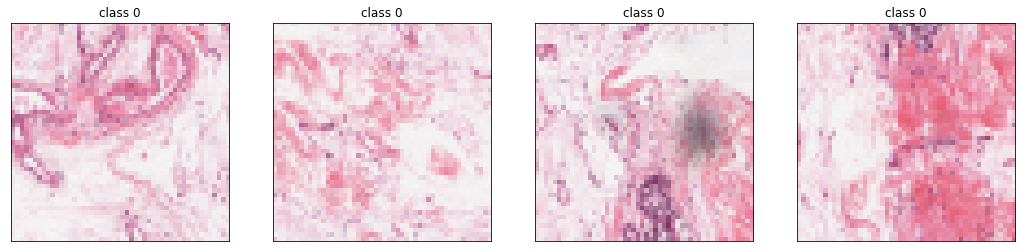

In [69]:
fig = plt.figure(figsize=(18,18))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(resized_images[i])
    ax.set_title('class {}'.format(classes[i]))

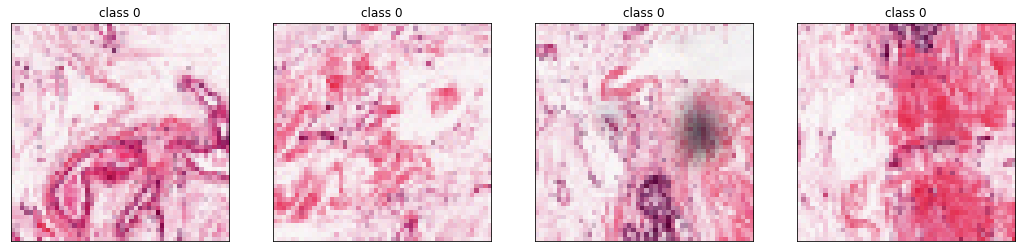

In [70]:
# Note that the augmentation process can drastically alter the pixel values, so need to normalise images

fig = plt.figure(figsize=(18,18))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    #normalized_image = exposure.rescale_intensity(augmented_images[i], out_range=(0, 1))
    ax.imshow(converted_images[i])
    ax.set_title('class {}'.format(classes[i]))

IndexError: list index out of range

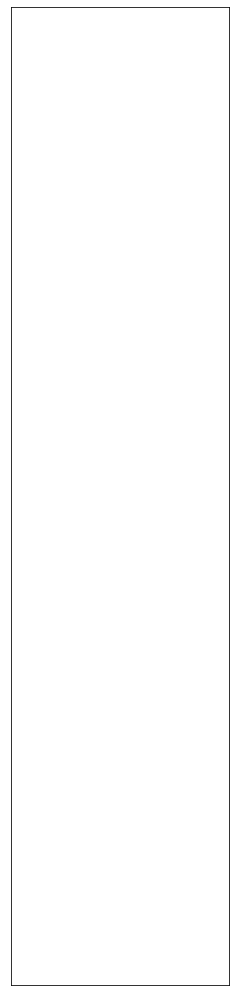

In [72]:
 fig = plt.figure(figsize=(18,18))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    #normalized_image = exposure.rescale_intensity(augmented_images[i], out_range=(0, 1))
    ax.imshow(test_images[i])
    ax.set_title('class {}'.format(classes[i]))

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split (test_images, classes, test_size = 0.3)

ValueError: Found input variables with inconsistent numbers of samples: [0, 1248]

In [ ]:
X_train = np.array(X_train)

In [ ]:
# To get the input shape right I need to find the height, width and channels of an image

In [ ]:
X_train

In [ ]:
X_train.shape

In [ ]:
model3 = Sequential()
model3.add(Conv2D(filters = 16,  
                 kernel_size = 5, 
                 strides = (2, 2), 
                 padding = 'same',
                 activation = 'relu'))
model3.add(MaxPool2D (pool_size = 2, 
                    strides = (2,2),
                    padding = 'same'))
model3.add(Flatten())
model3.add(Dense(250, activation = 'relu', input_shape = (873, 50,3)))
model3.add(Dropout(0.3))
model3.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy'] )
model3.fit(X_train, Y_train, epochs = 50, validation_split=0.2)

In [ ]:
x_train=tf.convert_to_tensor(x_train) 

#### Using datagen

In [ ]:
datagen = ImageDataGenerator(
           #width_shift_range = 0.1,
           #height_shift_range= 0.1,
           horizontal_flip = True,
           vertical_flip=True,
           rescale = 1/255)

In [ ]:
datagen.fit(X_train)

In [ ]:
X_subset = X_train[:4]

In [ ]:
fig = plt.figure(figsize=(18,18))
for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(resized_images[i])
    ax.set_title('class {}'.format(classes[i]))

In [ ]:
fig = plt.figure(figsize=(18,18))
for xbatch in datagen.flow(X_subset, batch_size=4):
 for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(xbatch[i])
    ax.set_title('class {}'.format(classes[i]))


In [ ]:
fig = plt.figure(figsize=(18,18))
for xbatch in datagen.flow(X_subset, batch_size=1):
 for i in range(4):
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(xbatch[0])
    ax.set_title('class {}'.format(classes[i]))
    if i == 3:
        break

In [ ]:
# Some notes from udacity gpt re loss functions
Of course! The 'loss' parameter in the model.compile() function is used to specify the loss function that will be optimized during training. The loss function measures how well the model is performing on the training data and guides the optimization process to minimize this value.

In Keras, the 'loss' parameter can take different values depending on the type of problem you are working on. Here are some commonly used loss functions for different types of tasks:

Binary Classification:

binary_crossentropy: This is the most common loss function for binary classification problems. It is used when you have two classes to predict.
Multiclass Classification:

categorical_crossentropy: This loss function is used for multiclass classification problems, where each input sample belongs to one and only one class.
sparse_categorical_crossentropy: Similar to categorical_crossentropy, but used when your targets are integer labels instead of one-hot encoded vectors.
Regression:

mean_squared_error: This loss function is commonly used for regression problems, where you are predicting a continuous value.
mean_absolute_error: Another loss function for regression, which measures the absolute difference between the predicted and true values.
Custom Loss Functions:

You can also define your own custom loss function by creating a function that takes the true labels and predicted values as inputs and returns a scalar value.
It's important to choose the appropriate loss function based on the problem you are trying to solve. The choice of loss function can have a significant impact on the performance of your model.

In [ ]:
# notes re optimizers 
Certainly! The optimizer is another important parameter in the model.compile() function. It determines how the model's weights are updated during training in order to minimize the loss function.

There are several optimizers available in Keras, each with its own advantages and use cases. Here are a few commonly used optimizers:

Adam: Adam stands for Adaptive Moment Estimation. It is an adaptive learning rate optimization algorithm that is well-suited for most applications. It combines the benefits of two other popular optimizers, AdaGrad and RMSProp, and performs well in a wide range of scenarios. Adam is often a good default choice.

RMSProp: RMSProp, short for Root Mean Square Propagation, is another popular optimizer. It adjusts the learning rate adaptively based on the average of the squared gradients. It is particularly effective in scenarios with sparse data or non-stationary objectives.

SGD: SGD stands for Stochastic Gradient Descent. It is a basic and widely-used optimizer that updates the weights based on the gradient of the loss function. SGD can be a good choice when working with large datasets or when fine-tuning models.

Adagrad: Adagrad adapts the learning rate for each parameter based on its historical gradients. It performs well in sparse data scenarios but may have difficulty converging in some cases.

Choosing the right optimizer depends on various factors such as the nature of your problem, the size of your dataset, and the architecture of your model. While Adam is often a good default choice, it is worth experimenting with different optimizers to find the one that works best for your specific task.

It's also important to note that the choice of optimizer can interact with other hyperparameters, such as learning rate and batch size. So, it's a good practice to experiment with different combinations to find the optimal configuration for your model.

In [ ]:
Yes, that's correct! In the given code snippet, the Conv2D and MaxPooling2D layers are responsible for extracting features from the input images before the training process begins in the first dense layer.

The Conv2D layer performs convolutional operations on the input images. It applies a set of filters to the input, sliding them across the image and computing dot products to extract features. These filters learn to recognize different patterns or features in the images.

The MaxPooling2D layer, on the other hand, performs downsampling by reducing the spatial dimensions of the feature maps obtained from the convolutional layers. It selects the maximum value within each pooling window, effectively reducing the size of the feature maps while retaining the most important information.

By stacking multiple convolutional and pooling layers, the model can learn hierarchical representations of the input images, capturing both low-level and high-level features. These learned features are then flattened and passed to the first dense layer for further processing and classification.

So, in summary, the Conv2D and MaxPooling2D layers extract meaningful features from the images, and the subsequent dense layers perform the classification based on these extracted features.

In [ ]:
When you specify the number of filters in a Conv2D layer, each filter learns to detect a specific pattern or feature in the input data. However, the exact patterns that the filters learn to recognize are not predetermined or predictable. The filters learn these patterns through the training process, adapting to the specific characteristics of the dataset.

In the early layers of a CNN, the filters often learn to detect simple features such as edges, corners, or textures. As you move deeper into the network, the filters can learn to detect more complex and abstract features that are relevant to the task at hand.

For example, in the case of image classification, the filters in the early layers might learn to detect basic shapes like lines or curves. As you go deeper into the network, the filters may start to recognize more complex patterns like shapes of objects or specific textures.

The specific patterns that the filters learn can vary depending on the dataset and the problem being solved. The network learns to extract the most informative features from the data during the training process, optimizing the filters to minimize the loss function.

It's important to note that the filters are not explicitly programmed to search for specific patterns. Instead, they learn to recognize patterns that are most relevant for the given task based on the training data.

That's cool. The data I'm working with is of images that feature a lot of blob like patterns. Given what you said about how the CNN adapts to the features present, could i afford to run a model with relatively few filters (e.g. 16)?

Yes, it is possible to run a model with relatively few filters, such as 16, especially if your images contain blob-like patterns. The number of filters determines the complexity and capacity of the model to capture different features in the data.

In the context of CNNs, filters act as feature detectors, learning to recognize specific patterns or features in the input images. By increasing the number of filters, the model has the potential to capture more diverse and intricate features. However, using too many filters can also increase the model's complexity and the number of parameters, which may lead to overfitting, especially if the dataset is small.

If your images primarily consist of blob-like patterns, it is possible that a smaller number of filters could be sufficient to capture and represent these patterns effectively. Starting with a smaller number of filters, such as 16, can be a reasonable approach. You can then evaluate the model's performance and gradually increase the number of filters if needed.

It's important to strike a balance between model complexity and the size of your dataset. Experimenting with different numbers of filters and evaluating the model's performance on a validation set can help you determine the optimal number of filters for your specific task.

In [ ]:
Of course! I'd be happy to help you with that. To perform data augmentation using preprocessing layers in Keras, you can follow these steps:

Step 1: Import the necessary libraries

import tensorflow as tf
from tensorflow.keras import layers
Step 2: Define your data augmentation pipeline using preprocessing layers

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
])
In this example, we are using three preprocessing layers: RandomFlip, RandomRotation, and RandomZoom. RandomFlip randomly flips the images horizontally, RandomRotation randomly rotates the images by a specified angle, and RandomZoom randomly zooms into the images by a specified factor.

Step 3: Apply the data augmentation pipeline to your dataset

augmented_images = data_augmentation(images)
Here, images is your original dataset of images. Applying the data_augmentation pipeline to images will generate augmented images.

Step 4: Train your model using the augmented images

model.fit(augmented_images, labels, ...)
You can now use the augmented images to train your model. Pass the augmented images and their corresponding labels to the fit method of your model.

That's it! These steps will allow you to perform data augmentation using preprocessing layers in Keras. Let me know if you have any questions or if there's anything else I can help you with!

In [ ]:
# Previous bucket permissions

{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "ListObjectsInBucket",
            "Effect": "Allow",
            "Principal": {
                "AWS": "arn:aws:iam::082990872438:root"
            },
            "Action": "s3:ListBucket",
            "Resource": "arn:aws:s3:::ldprojects"
        },
        {
            "Sid": "AllObjectActions",
            "Effect": "Allow",
            "Principal": {
                "AWS": "arn:aws:iam::082990872438:root"
            },
            "Action": "s3:*Object",
            "Resource": "arn:aws:s3:::ldprojects/*"
        },
        {
            "Sid": "AllowReadAccess",
            "Effect": "Allow",
            "Principal": {
                "AWS": "arn:aws:iam::082990872438:root"
            },
            "Action": "s3:GetObject",
            "Resource": "arn:aws:s3:::ldprojects/*"
        }
    ]
}

In [ ]:
Hi, I have done some data augmentation and need to put my new images into np arrays. Here is the code I've used- note that my original image data was a list of .png files:

augmentation = tf.keras.Sequential([
layers.RandomFlip("horizontal_and_vertical"),
layers.Rescaling( 1/255)])

augmented_images = []
for image in resized_images:
augmented_image = augmentation(image)
augmented_images.append(augmented_image)

augmented_array = [x.numpy() for x in augmented_images]

augmented_array2 = []

for img in augmented_array:
rescaled_imaged = (img * 255).astype('uint8')
augmented_array2.append(img)

converted_images = []

for img in augmented_array2:

image = tf.keras.preprocessing.image.array_to_img(img)
converted_images.append(image)

X_train = np.array(X_train)

However, the last commando brought up this message:

FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
X_train = np.array(X_train)
C:\Users\Laurence\AppData\Local\Temp\ipykernel_10848\1757705326.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
X_train = np.array(X_train)

It later leads to issues running my cnn. How can I fix this?


The warning message you received is indicating that the input object X_train is a list of arrays with different lengths or shapes, which is not compatible with creating a NumPy array directly using np.array(X_train). To fix this issue, you can use the np.stack() function instead, which will stack the arrays in X_train along a new axis and create a new NumPy array.

Here's the updated code:

X_train = np.stack(converted_images)
This will create a new NumPy array X_train with the stacked images from converted_images. Make sure that all the images in converted_images have the same shape before using np.stack().

Let me know if you have any further questions!

Thanks, I'll have a look into the np.stack method. Would resizing the images achieve a similar result?

Resizing the images will not achieve the same result as using np.stack(). Resizing the images changes their dimensions, while np.stack() is used to combine multiple arrays into a single array along a new axis.

If you want to resize the images, you can use the tf.image.resize() function from TensorFlow. Here's an example of how you can resize the images before stacking them:

resized_images = [tf.image.resize(image, (new_height, new_width)) for image in augmented_images]
X_train = np.stack(resized_images)
In this example, new_height and new_width represent the desired dimensions for the resized images. The tf.image.resize() function will resize each image in augmented_images to the specified dimensions.

Remember to import the necessary modules and define the values for new_height and new_width according to your requirements.

Let me know if you have any more questions!

Thanks. The reason I asked about resizing is that you said
"The warning message you received is indicating that the input object X_train is a list of arrays with different lengths or shapes, which is not compatible with creating a NumPy array directly using np.array(X_train)". I was wondering if resizing before using np.array() would allow it to work as the arrays would all the the shape

I apologize for any confusion caused. Resizing the images alone will not resolve the issue with creating a NumPy array directly using np.array(X_train) if the arrays in X_train have different lengths or shapes.

Resizing the images will only change their dimensions, but it will not address the issue of arrays with different lengths or shapes. To create a NumPy array from a list of arrays with different lengths or shapes, you would need to use a different approach, such as padding or cropping the images to a consistent size before stacking them.

If the arrays in X_train have different lengths or shapes, you will need to ensure that they have the same shape before using np.array(). Resizing the images can help achieve this consistency, but you may also need to consider other preprocessing steps depending on your specific requirements.

Let me know if you have any further questions!

Thank you. Can you please explain the difference between an images length / shape and its dimensions?

Certainly! In the context of image data, the terms "length/shape" and "dimensions" refer to different aspects.

Length/Shape: The length or shape of an image refers to the size or dimensions of the image data itself. For example, an image with a shape of (height, width) represents the number of pixels in the vertical and horizontal directions, respectively. The shape of an image determines its spatial resolution.

Dimensions: In the context of image data, the term "dimensions" typically refers to the number of channels in the image. An image can have different dimensions depending on the color space or representation. For example, a grayscale image has a single channel, while a RGB image has three channels (red, green, and blue). The dimensions of an image determine the color information it contains.

To summarize, the length/shape of an image refers to its size or dimensions in terms of pixels, while the dimensions of an image refer to the number of color channels it has.

Let me know if you have any further questions or need more clarification!

In [ ]:
https://www.geeksforgeeks.org/numpy-stack-in-python/